In [24]:
import nltk
import re
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from torch.utils.data import Dataset, DataLoader

nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorbarbarich/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Генерирование русских имен при помощи RNN

Датасет: https://disk.yandex.ru/i/2yt18jHUgVEoIw

1.1 На основе файла name_rus.txt создайте датасет.
  * Учтите, что имена могут иметь различную длину
  * Добавьте 4 специальных токена:
    * `<PAD>` для дополнения последовательности до нужной длины;
    * `<UNK>` для корректной обработки ранее не встречавшихся токенов;
    * `<SOS>` для обозначения начала последовательности;
    * `<EOS>` для обозначения конца последовательности.
  * Преобразовывайте строку в последовательность индексов с учетом следующих замечаний:
    * в начало последовательности добавьте токен `<SOS>`;
    * в конец последовательности добавьте токен `<EOS>` и, при необходимости, несколько токенов `<PAD>`;
  * `Dataset.__get_item__` возращает две последовательности: последовательность для обучения и правильный ответ.

  Пример:
  ```
  s = 'The cat sat on the mat'
  # преобразуем в индексы
  s_idx = [2, 5, 1, 2, 8, 4, 7, 3, 0, 0]
  # получаем x и y (__getitem__)
  x = [2, 5, 1, 2, 8, 4, 7, 3, 0]
  y = [5, 1, 2, 8, 4, 7, 3, 0, 0]
  ```

1.2 Создайте и обучите модель для генерации фамилии.

  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`;
  * Используйте рекуррентные слои;
  * Задача ставится как предсказание следующего токена в каждом примере из пакета для каждого момента времени. Т.е. в данный момент времени по текущей подстроке предсказывает следующий символ для данной строки (задача классификации);
  * Примерная схема реализации метода `forward`:
  ```
    input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
    emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
    output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
    output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
  ```

1.3 Напишите функцию, которая генерирует фамилию при помощи обученной модели:
  * Построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * Начальное скрытое состояние RNN `h_t = None`;
  * В результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * Выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * Повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности.

При обучении каждые `k` эпох генерируйте несколько фамилий и выводите их на экран.

In [182]:
# 1.1
data = pd.read_csv('data/name_rus.txt', encoding='cp1251', header=None, names=['surname'])
print(data.head())


class Vocab():
    def __init__(self, _data):
        self.max_surname_len = _data.surname.str.len().max()
        self.token_to_id = {}
        self.id_to_token = {}
        self.tech = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
        self.build_vocab(list('абвгдеёжзийклмнопрстуфхцчшщъыьэюя'))
        self.vocab_size = len(self.token_to_id)

    def build_vocab(self, letters):
        self.token_to_id = {token: idx for idx, token in enumerate(letters + self.tech)}
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}

    def __len__(self):
        return self.vocab_size

    def __getitem__(self, token):
        return self.token_to_id[token]

    def __contains__(self, token):
        return token in self.token_to_id

    def to_tokens(self, ids):
        # объединим id в одну строку
        ids_sub = []
        for idx in ids:
            if self.id_to_token[int(idx)] not in self.tech:
                ids_sub.append(self.id_to_token[int(idx)])

        return ''.join(ids_sub)

    def to_ids(self, tokens):
        out = [self.token_to_id['<SOS>']] + [self.token_to_id['<PAD>']] * self.max_surname_len
        for i, token in enumerate(tokens, 1):
            if token not in self.token_to_id:
                out[i] = self.token_to_id['<UNK>']
            else:
                out[i] = self.token_to_id[token]
        out.append(self.token_to_id['<EOS>'])
        return out


vocab = Vocab(data)
np.random.seed(21 * 3)

test_tokens = np.random.randint(0, 32, 6)
print('\n', test_tokens, sep='')
print(vocab.to_tokens(test_tokens))
print(vocab.to_ids(vocab.to_tokens(test_tokens)))
print(vocab.to_tokens((vocab.to_ids(vocab.to_tokens(test_tokens)))))

      surname
0     авдокея
1     авдоким
2      авдоня
3    авдотька
4  авдотьюшка

[12 20 11 23 18  0]
лукцса
[34, 12, 20, 11, 23, 18, 0, 33, 33, 33, 33, 33, 33, 33, 35]
лукцса


In [183]:
class SurnameDataset(Dataset):

    def __init__(self, _data, _vocab):
        self.data = _data
        self.vocab = _vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        _x = self.vocab.to_ids(self.data.surname.iloc[idx])
        return torch.tensor(_x[:-1]), torch.tensor(_x[1:])


dataset = SurnameDataset(data, vocab)
x, y = next(iter(dataset))
print(x, y)
print(vocab.to_tokens(x))
print(vocab.to_tokens(y))


tensor([34,  0,  2,  4, 15, 11,  5, 32, 33, 33, 33, 33, 33, 33]) tensor([ 0,  2,  4, 15, 11,  5, 32, 33, 33, 33, 33, 33, 33, 35])
авдокея
авдокея


In [623]:
class MyModelRNN(torch.nn.Module):

    def __init__(self, _vocab: Vocab, embedding_size, hidden_size):
        super(MyModelRNN, self).__init__()
        self.embedding = torch.nn.Embedding(_vocab.vocab_size, embedding_size)
        self.rnn = torch.nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1024)
        self.fc2 = torch.nn.Linear(1024, _vocab.vocab_size)
        self.f = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.25)
        self.vocab = _vocab

    def forward(self, x, h=None):
        x = self.embedding(x)
        x, h = self.rnn(x, h)
        x = self.dropout(self.fc(x))
        x = self.fc2(self.f(x))
        return x, h

In [624]:
model = MyModelRNN(vocab, 256, 128)
print(model(torch.tensor([vocab.to_ids(name) for name in ['виктор', 'егор']])))
model(torch.tensor([vocab.to_ids(name) for name in ['виктор', 'егор']]))[0].shape

(tensor([[[-0.1583, -0.1754, -0.0687,  ...,  0.5027,  0.4576,  0.2481],
         [-0.0879, -0.0688, -0.1442,  ...,  0.5764,  0.4303,  0.2866],
         [-0.1290, -0.1791, -0.0865,  ...,  0.5599,  0.4204,  0.2351],
         ...,
         [-0.0469, -0.1686, -0.0987,  ...,  0.5607,  0.5378,  0.1993],
         [-0.0599, -0.0944, -0.1398,  ...,  0.5910,  0.5559,  0.2506],
         [-0.1634, -0.1016, -0.1126,  ...,  0.4382,  0.4248,  0.2616]],

        [[-0.1352, -0.1613, -0.1342,  ...,  0.5043,  0.5104,  0.2488],
         [-0.0357, -0.0236, -0.0962,  ...,  0.5583,  0.4774,  0.2994],
         [-0.0011, -0.0983, -0.0771,  ...,  0.4263,  0.4676,  0.3169],
         ...,
         [-0.0387, -0.1488, -0.1440,  ...,  0.5926,  0.5473,  0.2543],
         [-0.1131, -0.1269, -0.1109,  ...,  0.5977,  0.5364,  0.2170],
         [-0.1290, -0.1142, -0.1508,  ...,  0.4518,  0.4052,  0.2350]]],
       grad_fn=<ViewBackward0>), tensor([[[-0.6351, -0.8441, -0.4356,  0.7489, -0.7070,  0.7037, -0.9311,
         

torch.Size([2, 15, 37])

In [625]:
def sample_next(model, x, prev_state, topk=5, uniform=True):
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)
    p = None if uniform else torch.nn.functional.softmax(top_logit.detach(), dim=-1).numpy()
    sampled_ix = np.random.choice(top_ix, p=p)
    return sampled_ix, state


def sample(model, start_letters, topk=5, uniform=False, max_seqlen=15, stop_on=None):
    model.eval()
    with torch.no_grad():
        sampled_ix_list = start_letters[:]
        x = torch.tensor([start_letters])

        prev_state = None
        for t in range(max_seqlen - len(start_letters)):
            sampled_ix, prev_state = sample_next(model, x, prev_state, topk, uniform)

            sampled_ix_list.append(sampled_ix)
            x = torch.tensor([[sampled_ix]])

            if sampled_ix == stop_on:
                break

    model.train()
    return sampled_ix_list


vocab.to_tokens(sample(model, [2], stop_on=vocab.token_to_id['<EOS>']))

'в'

In [626]:
def train(_model: torch.nn.Module, epochs=100):
    optimizer = torch.optim.Adam(_model.parameters())
    loss = torch.nn.CrossEntropyLoss()
    loss_log = []
    loader = DataLoader(dataset, batch_size=512)
    for i in range(epochs):
        epoch_loss = 0
        j = 1  # Делители running losses
        _model.train()
        for j, (batch_x, batch_y) in enumerate(loader):
            y_pred = _model(batch_x)
            running_loss = loss(y_pred[0].reshape(-1, vocab.vocab_size), batch_y.reshape(-1))
            epoch_loss += running_loss.item()

            running_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        _model.eval()
        epoch_loss /= j

        if i % 25 == 0:
            print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f}')

            eos = vocab.token_to_id['<EOS>']
            start = vocab.to_ids('викт')[1:5]
            samples = [vocab.to_tokens(sample(model, start, stop_on=eos)) for _ in range(3)]
            print('Викт ---> ', *samples, sep=' | ')

        loss_log.append(epoch_loss)

    return _model, loss_log


model, loss_log = train(model, epochs=76)

EPOCH:   1 	 LOSS: 3.6692
Викт --->  | викт | виктаа | викта
EPOCH:  26 	 LOSS: 1.5651
Викт --->  | викта | виктуста | викта
EPOCH:  51 	 LOSS: 1.4023
Викт --->  | викта | виктюша | викта
EPOCH:  76 	 LOSS: 1.2222
Викт --->  | виктинка | виктава | виктиника


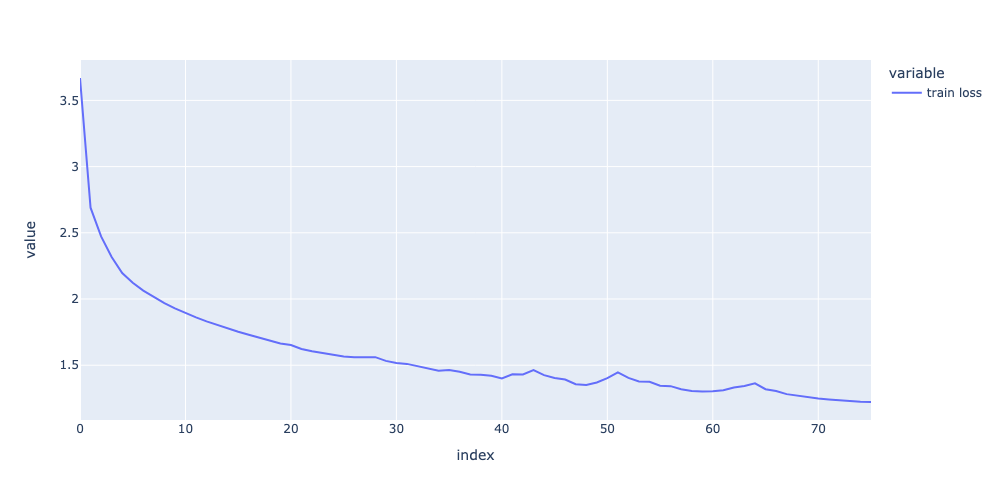

In [627]:
px.line(pd.DataFrame({'train loss': loss_log})).show(renderer='png', width=1000)

In [628]:
eos = vocab.token_to_id['<EOS>']
start = vocab.to_ids('викт')[1:5]
samples = [vocab.to_tokens(sample(model, start, stop_on=eos)) for _ in range(10)]
print('Викт ---> ', *samples, sep=' | ')

Викт --->  | викта | виктьюня | викта | викта | виктана | викта | виктий | викта | викта | викта


## 2. Генерирование текста при помощи RNN

2.1 Скачайте из интернета какое-нибудь художественное произведение
  * Выбирайте достаточно крупное произведение, чтобы модель лучше обучалась;

2.2 На основе выбранного произведения создайте датасет. 

Отличия от задачи 1:
  * Токены <SOS>, `<EOS>` и `<UNK>` можно не добавлять;
  * При создании датасета текст необходимо предварительно разбить на части. Выберите желаемую длину последовательности `seq_len` и разбейте текст на построки длины `seq_len` (можно без перекрытия, можно с небольшим перекрытием).

2.3 Создайте и обучите модель для генерации текста
  * Задача ставится точно так же как в 1.2;
  * При необходимости можете применить:
    * двухуровневые рекуррентные слои (`num_layers`=2)
    * [обрезку градиентов](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

2.4 Напишите функцию, которая генерирует фрагмент текста при помощи обученной модели
  * Процесс генерации начинается с небольшого фрагмента текста `prime`, выбранного вами (1-2 слова) 
  * Сначала вы пропускаете через модель токены из `prime` и генерируете на их основе скрытое состояние рекуррентного слоя `h_t`;
  * После этого вы генерируете строку нужной длины аналогично 1.3


In [48]:
with open('./data/dubrovskiy.txt', encoding='cp1251') as file:
    text = file.read()

text = nltk.word_tokenize(re.sub(r'[^A-Z]', '', text.lower(), -1), 'russian')
text[:3]

['александр', 'сергеевич', 'пушкин']

In [50]:
from tqdm import tqdm


class TextDataset(Dataset):

    def __init__(self, text, seq_len):
        self.text = text
        self.seq_len = seq_len
        self.tokens = list(set(text)) + [' ', '']
        self.token_to_id = {token: idx for idx, token in enumerate(self.tokens)}
        self.id_to_token = {idx: token for idx, token in enumerate(self.tokens)}
        self.num_tokens = len(self.tokens)

    def __len__(self):
        return len(self.text) // self.seq_len

    def __getitem__(self, idx):
        start_idx = idx * self.seq_len
        end_idx = start_idx + self.seq_len + 1
        text_str = self.text[start_idx:end_idx]
        text_encoded = [self.token_to_id[token] for token in text_str]
        x = torch.tensor(text_encoded[:-1])
        y = torch.tensor(text_encoded[1:])
        return x, y

    def decode(self, text_encoded):
        out = ''
        for idx in text_encoded:
            if int(idx) in self.id_to_token.keys():
                out += self.id_to_token[int(idx)]

            out += ' '

        return out

    def encode(self, text):
        out = []
        for token in text:
            if token in self.token_to_id:
                out.append(self.token_to_id[token])
            else:
                out.append(self.token_to_id[' '])
        return torch.tensor(out)

    def collate_fn(self, batch):
        x = torch.stack([item[0] for item in batch])
        y = torch.stack([item[1] for item in batch])
        return x, y

    def generate_batch(self, batch_size, seq_len, device='cpu'):
        while True:
            x = torch.randint(self.num_tokens, (batch_size, seq_len), dtype=torch.long, device=device)
            y = torch.randint(self.num_tokens, (batch_size, seq_len), dtype=torch.long, device=device)
            yield x, y


class RNN(torch.nn.Module):

    def __init__(self, num_tokens, emb_size, rnn_num_units, num_layers=1, dropout=0.5):
        super().__init__()
        self.emb = torch.nn.Embedding(num_tokens, emb_size)
        self.rnn = torch.nn.LSTM(emb_size, rnn_num_units, num_layers=num_layers, dropout=dropout)
        self.hid_to_logits = torch.nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        x = self.emb(x)
        x, _ = self.rnn(x)
        x = self.hid_to_logits(x)
        return x


def generate_sample(model, dataset, prime_str=' ', sample_len=100):
    model.eval()
    with torch.no_grad():
        x = dataset.encode(prime_str)
        x = x[None, :].to(next(model.parameters()).device)
        for _ in range(sample_len):
            logits = model(x)
            p_next = torch.nn.functional.softmax(logits[:, -1], dim=-1)
            next_token = torch.multinomial(p_next, num_samples=1)
            x = torch.cat([x, next_token], dim=1)
        return dataset.decode(x[0].cpu())


def train(model, dataset, num_epochs, batch_size, lr=1e-3, grad_clip=5, device='cpu'):

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    loader = DataLoader(dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for x, y in tqdm(loader, leave=False):
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits.transpose(1, 2), y)
            loss.backward()
            epoch_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        if epoch % 5 == 0:
            print(f'Epoch: {epoch + 1}, Loss: {epoch_loss:.4f}')
            print(generate_sample(model, dataset, sample_len=dataset.seq_len))


dataset = TextDataset(text, seq_len=15)
model = RNN(num_tokens=dataset.num_tokens, emb_size=256, rnn_num_units=256, num_layers=3, dropout=0.25)
train(model, dataset, num_epochs=50, batch_size=512)


Epoch: 1, Loss: 35.2681
  иного мир качал решительность подвиг никому дороги фуражке опустела проворчала бесчувственность пойти похороны приличного полагаюсь 


Epoch: 6, Loss: 27.0131
  замечено фитиль от прижавшегося дала отправлены проворство отличалась конурке статься молодость долгое виновником куста возвращалась 


Epoch: 11, Loss: 26.7882
  вкусу повелительным отворил спрятать злодеями ступайте место свою заяц разбранил весело расспрашивая ахти давали быв 


Epoch: 16, Loss: 26.7490
  въехал приказывала географии шкурку андрею вился обратно кириловны учителем картинах поселился героиня прошел следствия общего 


Epoch: 21, Loss: 26.7422
  твердили -тут предрассудках важно противу законные спустит утопить побежали твоем собачьем честолюбив определиться ревом дворню 


Epoch: 26, Loss: 26.7394
  поклон твое родился гостей вынести лекарем пробовать вошел некоторое говором мошенничество позвал залу покойник неподвижен 


Epoch: 31, Loss: 26.7345
  прекратил пушками избавить внимания новой регламента сведем удивительного дочери начиналась дамы фонтанами шел скончался большим 


Epoch: 36, Loss: 26.7239
  коли широкая это лучше кладбище должны тараса сено приятно оказывать сходствовали миша по нашего просунул 


Epoch: 41, Loss: 26.7037
  запоздалой отпуске помянутого молодцу застать надлежало андреевича волнением слугу понравился ямщик взглянул продано умереть ногою 


Epoch: 46, Loss: 26.6686
  9 например маскированного личным знала разошлись грабительства ободранного раны беспокоился несчастном потемках дворовый что сотвори 
